In [170]:
import pandas as pd 
from useful_funcs import *

# Getting dfs

In [171]:
gw1_url = "https://raw.githubusercontent.com/vaastav/Fantasy-Premier-League/refs/heads/master/data/2024-25/gws/gw1.csv"
gw1_df = pd.read_csv(gw1_url, index_col=0)

In [172]:
gw_df_list = []
for i in range(1, 39):
    gw_url = f"https://raw.githubusercontent.com/vaastav/Fantasy-Premier-League/refs/heads/master/data/2024-25/gws/gw{i}.csv"
    gw_df = pd.read_csv(gw_url, index_col=0)
    gw_df['gw'] = i
    gw_df_list.append(gw_df)

In [173]:
gw_df = pd.concat(gw_df_list)

# Cleaning up dataframe

In [174]:
gw_df.columns

Index(['position', 'team', 'xP', 'assists', 'bonus', 'bps', 'clean_sheets',
       'creativity', 'element', 'expected_assists',
       'expected_goal_involvements', 'expected_goals',
       'expected_goals_conceded', 'fixture', 'goals_conceded', 'goals_scored',
       'ict_index', 'influence', 'kickoff_time', 'minutes', 'modified',
       'opponent_team', 'own_goals', 'penalties_missed', 'penalties_saved',
       'red_cards', 'round', 'saves', 'selected', 'starts', 'team_a_score',
       'team_h_score', 'threat', 'total_points', 'transfers_balance',
       'transfers_in', 'transfers_out', 'value', 'was_home', 'yellow_cards',
       'gw', 'mng_clean_sheets', 'mng_draw', 'mng_goals_scored', 'mng_loss',
       'mng_underdog_draw', 'mng_underdog_win', 'mng_win'],
      dtype='object')

In [175]:
gw_df['team_goals'] = gw_df.apply(lambda row: get_team_goals(row['was_home'], row['team_h_score'], row['team_a_score']), axis=1)
gw_df['opponent_goals'] = gw_df.apply(lambda row: get_opponent_goals(row['was_home'], row['team_h_score'], row['team_a_score']), axis=1)
gw_df['team_points'] = gw_df.apply(lambda row: get_team_points(row['was_home'], row['team_h_score'], row['team_a_score']), axis=1)
gw_df['opponent_points'] = gw_df['team_points'].apply(get_opponent_points)

In [176]:
gw_df['full_name'] = [clean_name(idx) for idx in gw_df.index]

In [177]:
gw_df.columns

Index(['position', 'team', 'xP', 'assists', 'bonus', 'bps', 'clean_sheets',
       'creativity', 'element', 'expected_assists',
       'expected_goal_involvements', 'expected_goals',
       'expected_goals_conceded', 'fixture', 'goals_conceded', 'goals_scored',
       'ict_index', 'influence', 'kickoff_time', 'minutes', 'modified',
       'opponent_team', 'own_goals', 'penalties_missed', 'penalties_saved',
       'red_cards', 'round', 'saves', 'selected', 'starts', 'team_a_score',
       'team_h_score', 'threat', 'total_points', 'transfers_balance',
       'transfers_in', 'transfers_out', 'value', 'was_home', 'yellow_cards',
       'gw', 'mng_clean_sheets', 'mng_draw', 'mng_goals_scored', 'mng_loss',
       'mng_underdog_draw', 'mng_underdog_win', 'mng_win', 'team_goals',
       'opponent_goals', 'team_points', 'opponent_points', 'full_name'],
      dtype='object')

## New

In [178]:
gw_df.columns

Index(['position', 'team', 'xP', 'assists', 'bonus', 'bps', 'clean_sheets',
       'creativity', 'element', 'expected_assists',
       'expected_goal_involvements', 'expected_goals',
       'expected_goals_conceded', 'fixture', 'goals_conceded', 'goals_scored',
       'ict_index', 'influence', 'kickoff_time', 'minutes', 'modified',
       'opponent_team', 'own_goals', 'penalties_missed', 'penalties_saved',
       'red_cards', 'round', 'saves', 'selected', 'starts', 'team_a_score',
       'team_h_score', 'threat', 'total_points', 'transfers_balance',
       'transfers_in', 'transfers_out', 'value', 'was_home', 'yellow_cards',
       'gw', 'mng_clean_sheets', 'mng_draw', 'mng_goals_scored', 'mng_loss',
       'mng_underdog_draw', 'mng_underdog_win', 'mng_win', 'team_goals',
       'opponent_goals', 'team_points', 'opponent_points', 'full_name'],
      dtype='object')

## Finding ewma for player stats

In [179]:
gw_df_players = gw_df[['assists', 'bonus', 'bps', 'clean_sheets', 'goals_conceded', 'goals_scored',
                      'influence', 'creativity', 'threat', 'ict_index', 'minutes',
                        'gw', 'full_name', 'total_points', 'position', 'team', 'opponent_team']]

In [180]:
gw_df_players_reset_index = gw_df_players.reset_index()

In [181]:
# Ensure the DataFrame is sorted by 'full_name' and 'gw'
simple_gw_df_reset_index = gw_df_players_reset_index.sort_values(['full_name', 'gw'])

# List of columns to apply EWMA to
# value_cols = ['influence', 'creativity', 'threat', 'ict_index', 'team_goals', 'opponent_goals', 'minutes']
value_cols = ['assists', 'bonus', 'bps', 'clean_sheets', 'goals_conceded', 'goals_scored',
                      'influence', 'creativity', 'threat', 'ict_index', 'minutes', 'total_points']

# Apply EWMA within each group
ewma_gw_df_players = (
    simple_gw_df_reset_index
    .groupby('full_name', group_keys=False)
    [value_cols]
    .apply(lambda x: x.ewm(alpha=0.3, adjust=False).mean())
)
ewma_gw_df_players.rename(columns={'total_points': 'ewma_total_points'}, inplace=True)
ewma_gw_df_players = simple_gw_df_reset_index[['full_name', 'gw', 'total_points', 'position','team','opponent_team']].join(ewma_gw_df_players)

## Finding ewma for team stats

In [182]:
gw_df.columns

Index(['position', 'team', 'xP', 'assists', 'bonus', 'bps', 'clean_sheets',
       'creativity', 'element', 'expected_assists',
       'expected_goal_involvements', 'expected_goals',
       'expected_goals_conceded', 'fixture', 'goals_conceded', 'goals_scored',
       'ict_index', 'influence', 'kickoff_time', 'minutes', 'modified',
       'opponent_team', 'own_goals', 'penalties_missed', 'penalties_saved',
       'red_cards', 'round', 'saves', 'selected', 'starts', 'team_a_score',
       'team_h_score', 'threat', 'total_points', 'transfers_balance',
       'transfers_in', 'transfers_out', 'value', 'was_home', 'yellow_cards',
       'gw', 'mng_clean_sheets', 'mng_draw', 'mng_goals_scored', 'mng_loss',
       'mng_underdog_draw', 'mng_underdog_win', 'mng_win', 'team_goals',
       'opponent_goals', 'team_points', 'opponent_points', 'full_name'],
      dtype='object')

In [183]:
gw_df_team = gw_df[['team', 'gw', 'team_goals']]



In [184]:
gw_df_team2 = gw_df_team.groupby(['team', 'gw']).first().reset_index()

In [193]:
# Ensure the DataFrame is sorted by 'full_name' and 'gw'
gw_df_team_sorted = gw_df_team2.sort_values(['team', 'gw'])

# List of columns to apply EWMA to
# value_cols = ['influence', 'creativity', 'threat', 'ict_index', 'team_goals', 'opponent_goals', 'minutes']
value_cols = ['team_goals']

# Apply EWMA within each group
ewma_gw_df_team = (
    gw_df_team_sorted
    .groupby('team', group_keys=False)
    [value_cols]
    .apply(lambda x: x.ewm(alpha=0.3, adjust=False).mean())
)

ewma_gw_df_team.rename(columns={'team_goals': 'ewma_team_goals'}, inplace=True)
ewma_gw_df_team = gw_df_team_sorted[['team', 'gw']].join(ewma_gw_df_team)

## Merging team and player ewma

In [194]:
teams_url = 'https://raw.githubusercontent.com/vaastav/Fantasy-Premier-League/refs/heads/master/data/2024-25/teams.csv'
teams = pd.read_csv(teams_url)

teamcode_dict = dict(zip(teams['id'], teams['name']))
ewma_gw_df_players['opponent_team_name'] = ewma_gw_df_players['opponent_team'].map(teamcode_dict)

In [195]:
ewma_gw_df_players

,full_name,gw,total_points,position,team,opponent_team,assists,bonus,bps,clean_sheets,goals_conceded,goals_scored,influence,creativity,threat,ict_index,minutes,ewma_total_points,opponent_team_name
17247,aaron_anselmino,25,0,DEF,Chelsea,5,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,Brighton
18040,aaron_anselmino,26,0,DEF,Chelsea,2,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,Aston Villa
18823,aaron_anselmino,27,0,DEF,Chelsea,17,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,Southampton
19611,aaron_anselmino,28,0,DEF,Chelsea,11,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,Leicester
20269,aaron_anselmino,29,0,DEF,Chelsea,1,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,Arsenal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24333,zain_silcott_duberry,34,0,MID,Bournemouth,14,0.0,0.0,0.029660,0.0,0.0,0.0,0.011864,0.005932,0.0,0.001780,0.005932,0.005932,Man Utd
25118,zain_silcott_duberry,35,0,MID,Bournemouth,1,0.0,0.0,0.020762,0.0,0.0,0.0,0.008305,0.004152,0.0,0.001246,0.004152,0.004152,Arsenal
25919,zain_silcott_duberry,36,0,MID,Bournemouth,2,0.0,0.0,0.014533,0.0,0.0,0.0,0.005813,0.002907,0.0,0.000872,0.002907,0.002907,Aston Villa
26720,zain_silcott_duberry,37,0,MID,Bournemouth,13,0.0,0.0,0.010173,0.0,0.0,0.0,0.004069,0.002035,0.0,0.000610,0.002035,0.002035,Man City


In [200]:
ewma_gw_df_opponent_team = ewma_gw_df_team.rename(columns={'team': 'opponent_team_name', 'ewma_team_goals': 'ewma_opponent_goals'})

In [198]:
ewma_gw_df = ewma_gw_df_players.merge(ewma_gw_df_team, on=['team', 'gw'], how='left')
ewma_gw_df = ewma_gw_df.merge(ewma_gw_df_opponent_team, on=['opponent_team_name', 'gw'], how='left')

In [199]:
ewma_gw_df

,full_name,gw,total_points,position,team,opponent_team,assists,bonus,bps,clean_sheets,...,goals_scored,influence,creativity,threat,ict_index,minutes,ewma_total_points,opponent_team_name,ewma_team_goals,ewma_opponent_goals
0,aaron_anselmino,25,0,DEF,Chelsea,5,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,Brighton,1.210430,1.547687
1,aaron_anselmino,26,0,DEF,Chelsea,2,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,Aston Villa,1.147301,1.287454
2,aaron_anselmino,27,0,DEF,Chelsea,17,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,Southampton,2.003111,0.588015
3,aaron_anselmino,28,0,DEF,Chelsea,11,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,Leicester,1.702177,0.143231
4,aaron_anselmino,29,0,DEF,Chelsea,1,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,Arsenal,1.191524,1.103608
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27600,zain_silcott_duberry,34,0,MID,Bournemouth,14,0.0,0.0,0.029660,0.0,...,0.0,0.011864,0.005932,0.0,0.001780,0.005932,0.005932,Man Utd,0.968566,0.768019
27601,zain_silcott_duberry,35,0,MID,Bournemouth,1,0.0,0.0,0.020762,0.0,...,0.0,0.008305,0.004152,0.0,0.001246,0.004152,0.004152,Arsenal,1.277996,1.719443
27602,zain_silcott_duberry,36,0,MID,Bournemouth,2,0.0,0.0,0.014533,0.0,...,0.0,0.005813,0.002907,0.0,0.000872,0.002907,0.002907,Aston Villa,0.894598,1.836243
27603,zain_silcott_duberry,37,0,MID,Bournemouth,13,0.0,0.0,0.010173,0.0,...,0.0,0.004069,0.002035,0.0,0.000610,0.002035,0.002035,Man City,0.926218,1.804044


## Old

In [ ]:
simple_gw_df = gw_df[['assists', 'bonus', 'bps', 'clean_sheets', 'goals_conceded', 'goals_scored',
                      'influence', 'creativity', 'threat', 'ict_index', 'team_goals', 'opponent_goals', 'minutes',
                        'gw', 'full_name', 'total_points', 'position']]

In [ ]:
simple_gw_df_reset_index = simple_gw_df.reset_index(drop=True)

In [ ]:
# Ensure the DataFrame is sorted by 'full_name' and 'gw'
simple_gw_df_reset_index = simple_gw_df_reset_index.sort_values(['full_name', 'gw'])

# List of columns to apply EWMA to
# value_cols = ['influence', 'creativity', 'threat', 'ict_index', 'team_goals', 'opponent_goals', 'minutes']
value_cols = ['assists', 'bonus', 'bps', 'clean_sheets', 'goals_conceded', 'goals_scored',
                      'influence', 'creativity', 'threat', 'ict_index', 'team_goals', 'opponent_goals', 'minutes']

# Apply EWMA within each group
ewma_simple_gw_df = (
    simple_gw_df_reset_index
    .groupby('full_name', group_keys=False)
    [value_cols]
    .apply(lambda x: x.ewm(alpha=0.3, adjust=False).mean())
)

ewma_simple_gw_df = simple_gw_df_reset_index[['full_name', 'gw', 'total_points', 'position']].join(ewma_simple_gw_df)

In [ ]:
player_gt_0_points = ewma_simple_gw_df.groupby('full_name').sum().query('total_points>0').index

In [ ]:
ewma_simple_gw_df_f1 = ewma_simple_gw_df.query('full_name in @player_gt_0_points')
ewma_simple_gw_df_f2 = ewma_simple_gw_df_f1.query('gw>9')

In [ ]:
ewma_simple_gw_df_f1.query('full_name=="erling_haaland"')[['gw', 'minutes']]

,gw,minutes
232,1,90.000000
851,2,89.700000
1484,3,89.790000
2135,4,89.853000
2794,5,89.897100
3456,6,89.927970
4120,7,89.949579
4786,8,89.964705
5454,9,89.975294
6126,10,89.982706


In [ ]:
simple_gw_df_reset_index.query('full_name=="erling_haaland"')[['gw', 'minutes']]

,gw,minutes
232,1,90
851,2,89
1484,3,90
2135,4,90
2794,5,90
3456,6,90
4120,7,90
4786,8,90
5454,9,90
6126,10,90


# Trying some models

## Random forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
ewma_simple_gw_df_f2_fwd = ewma_simple_gw_df_f2.query('position=="FWD"').set_index(['full_name', 'gw'])
X = ewma_simple_gw_df_f2_fwd[['assists', 'bonus', 'bps', 'clean_sheets', 'goals_conceded',
                              'goals_scored', 'influence', 'creativity', 'threat', 'ict_index',
                              'team_goals', 'opponent_goals', 'minutes']]
y = ewma_simple_gw_df_f2_fwd['total_points']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [ ]:
model = RandomForestClassifier(random_state=0)
model.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [ ]:
y_pred = model.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score

print('Model accuracy score with 10 decision-trees : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Model accuracy score with 10 decision-trees : 0.6673


# Lin regress

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
model = LinearRegression()
model.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [ ]:
y_pred = model.predict(X_test)

In [ ]:
# accuracy_score(y_test, y_pred)

In [ ]:
y_test_df = y_test.to_frame(name='y_test')
y_test_df['y_pred'] = y_pred

<Axes: xlabel='y_test', ylabel='y_pred'>

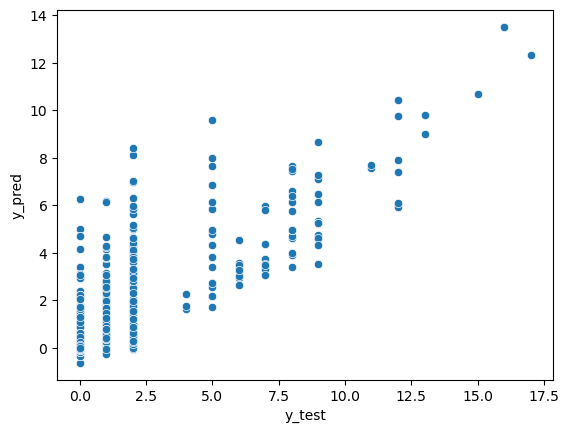

In [ ]:
from scipy.stats import linregress

sns.scatterplot(data=y_test_df, x='y_test', y='y_pred')

## xGBoost

In [ ]:
from xgboost import XGBClassifier

model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
model.fit(X_train, y_train)

ValueError: Invalid classes inferred from unique values of `y`.  Expected: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17], got [-2 -1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 16 17]

In [ ]:
y_train

full_name                 gw
liam_delap                28     2
niclas_fullkrug           35     2
taiwo_awoniyi             31     0
rasmus_hojlund            15     8
dominic_solanke_mitchell  38     7
                                ..
michail_antonio           19     0
odsonne_edouard           38     0
jean_philippe_mateta      22    13
remy_rees_dottin          22     1
michail_antonio           15     0
Name: total_points, Length: 1153, dtype: int64